# Machine Learning
# TP4: Gradient Descent

We will study several gradient descent methods, including the ordinary gradient descent and gradient descents with first and second moments.

### Surfaces

We will use the following plotting tools.

In [2]:
#This cell sets up basic plotting functions awe
#we will use to visualize the gradient descent routines.

#Make plots interactive
#%matplotlib notebook

#Make plots static
%matplotlib inline

#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm
#from itertools import zip_longest

#Import Numpy
import numpy as np

#Define function for plotting 

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-2, 2)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)
    
    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)
    
    return ax;

    
def overlay_trajectory_contour_M(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=14)
    return ax;

def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

A saddle point:

In [3]:
#Define monkey saddle and gradient
def monkey_saddle(x,y):
    return x**3 - 3*x*y**2

def grad_monkey_saddle(params):
    x=params[0]
    y=params[1]
    grad_x= 3*x**2-3*y**2
    grad_y= -6*x*y
    return [grad_x,grad_y]

A quardratic minimum:

In [26]:
# Define minima_surface

def minima_surface(x,y,a=1,b=1):
    return a*x**2+b*y**2-1

def grad_minima_surface(params,a=1, b=1):
    x=params[0]
    y=params[1]
    grad_x= 2*a*x
    grad_y= 2*b*y
    return [grad_x,grad_y]

And Beales's function:

In [5]:
def beales_function(x,y):
    return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    return f

def grad_beales_function(params):
    x=params[0]
    y=params[1]
    grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
    grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
    return [grad_x,grad_y]

def contour_beales_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=beales_function(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(3,0.5, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig,ax

Let's plot them:

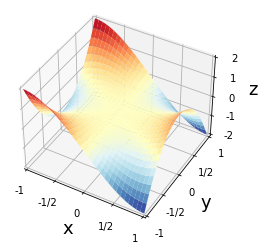

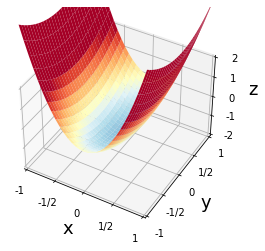

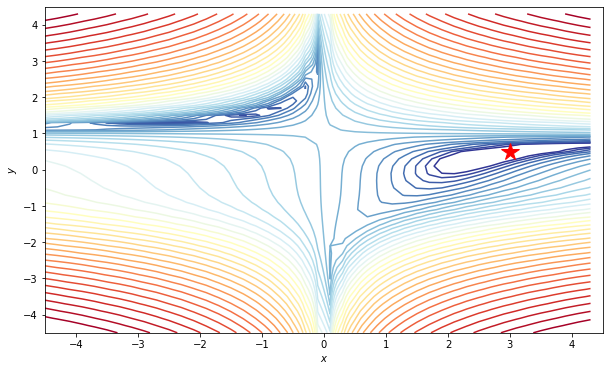

In [8]:
#Make plots of surfaces
plt.close() # closes previous plots
x, y = np.mgrid[-1:1:31j, -1:1:31j]
fig1,ax1=plot_surface(x,y,monkey_saddle(x,y))
#fig2,ax2=plot_surface(x,y,saddle_surface(x,y))
fig3,ax3=plot_surface(x,y,minima_surface(x,y,5))

#Contour plot of Beale's Function

fig4,ax4 =contour_beales_function()
plt.show()

## Gradient descent

Ordinary Gradient Descent:

In [134]:
#This writes a simple gradient descent, gradient descent+ momentum,
#nesterov. 

#Mean-gradient based methods
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0):
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+ noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

Gradient Descent with momentum:

In [22]:
def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

Nesterov Accelerated Gradient (NAG):

In [23]:
def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

### Experiments

- **Stuying the parameters of the simplest GD:**

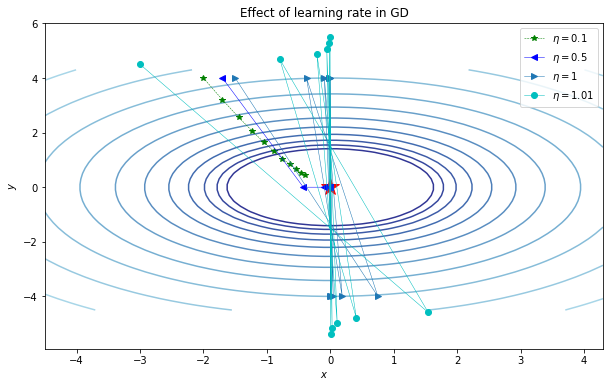

In [85]:
plt.close()
a,b = 0.75, 1.
func_param = (a, b)

x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
gd_1=gd(grad_minima_surface,init1, func_param, n_epochs=10, eta=eta1)
gd_2=gd(grad_minima_surface,init2, func_param, n_epochs=10, eta=eta2)
gd_3=gd(grad_minima_surface,init3, func_param, n_epochs=10, eta=eta3)
gd_4=gd(grad_minima_surface,init4, func_param, n_epochs=10, eta=eta4)

overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)

plt.title("Effect of learning rate in GD")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

Qualitative behaviors with respect to the learning rate $\eta$:
 - ($\eta = 0.1$) the method converges with many small steps;
 - ($\eta = 0.5$) the method converges with one step only -- the fastest;
 - ($\eta = 1.$) the method oscillates around the minimum but does not converge;
 - ($\eta = 1.01$) the method oscillates around the minimum and diverges!

Conclusion: Choosing the learning rate parameter wisely is paramount.

The optimum learning rate depends on the local landscape, as one can see from changing the $a$ and $b$ parameters. In presence of anistropy, the convergence time also depends on the initial position.

- **Comparing ordinary GD with methods using the first momentum:**

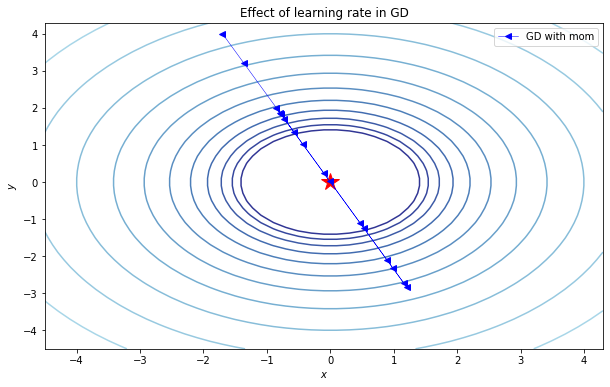

In [124]:
# Comparing GD with CM and NAG
plt.close()
a,b = 1., 1.

x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
gd_1=gd(grad_minima_surface,init1, n_epochs=10, eta=eta1)
gd_2=gd_with_mom(grad_minima_surface, init2, n_epochs=15, eta=eta1)
gd_3=NAG(grad_minima_surface, init3, n_epochs=20, eta=eta1)

#overlay_trajectory_contour(ax,gd_1,'GD','g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'GD with mom','b-<', lw=0.5)
#overlay_trajectory_contour(ax,gd_3,'NAG','->', lw=0.5)
#overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)

plt.title("Effect of learning rate in GD")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

The learning rates for GD with momentum and NAG must be set smaller than for GD??

## Using the second moment

RMSprop method:

In [106]:
def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj

Adams method:

In [108]:
def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

Plotting the paths for GD, GDmom, NAG, RMSprop, ADAM with different starting points.

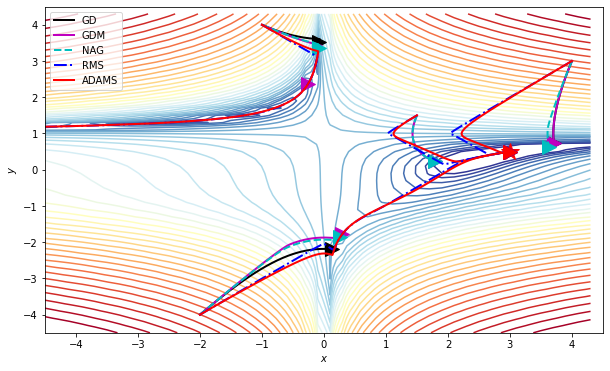

In [139]:
plt.close()
#Make static plot of the results
Nsteps=10**4
lr_l=10**-3
lr_s=10**-6

init1=np.array([4,3])
fig1, ax1=contour_beales_function()

gd_trajectory1=gd(grad_beales_function,init1,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory1=gd_with_mom(grad_beales_function,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory1=NAG(grad_beales_function,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory1=rms_prop(grad_beales_function,init1,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory1=adams(grad_beales_function,init1,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GD','k')
overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory1, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory1,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory1,'ADAMS', 'r')

plt.legend(loc=2)

init2=np.array([1.5,1.5])
gd_trajectory2=gd(grad_beales_function,init2,Nsteps, eta=10**-6, noise_strength=0)
gdm_trajectory2=gd_with_mom(grad_beales_function,init2,Nsteps,eta=10**-6, gamma=0.9,noise_strength=0)
NAG_trajectory2=NAG(grad_beales_function,init2,Nsteps,eta=10**-6, gamma=0.9,noise_strength=0)
rms_prop_trajectory2=rms_prop(grad_beales_function,init2,Nsteps,eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory2=adams(grad_beales_function,init2,Nsteps,eta=10**-3, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gdm_trajectory2, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory2, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory2,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory2,'ADAMS', 'r')

init3=np.array([-1,4])

gd_trajectory3=gd(grad_beales_function,init3,10**5, eta=lr_s, noise_strength=0)
gdm_trajectory3=gd_with_mom(grad_beales_function,init3,10**5,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory3=NAG(grad_beales_function,init3,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory3=rms_prop(grad_beales_function,init3,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory3=adams(grad_beales_function,init3,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory3, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory3, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory3, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory3,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory3,'ADAMS', 'r')

init4=np.array([-2,-4])

gd_trajectory4=gd(grad_beales_function,init4,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory4=gd_with_mom(grad_beales_function,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory4=NAG(grad_beales_function,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory4=rms_prop(grad_beales_function,init4,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory4=adams(grad_beales_function,init4,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory4, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory4, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory4, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory4,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory4,'ADAMS', 'r')


plt.show()

GD, GDM, NAG tend to get stuck in flat places, while RMS and ADAM manage mode often to leap further and find the global minimum.

Learning rate at $10^{-6}$:

/home/Master_IA/.conda/envs/IA/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/home/Master_IA/.conda/envs/IA/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/home/Master_IA/.conda/envs/IA/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/Master_IA/.conda/envs/IA/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/Master_IA/.conda/envs/IA/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/home/Master_IA/.conda/envs/IA/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/home/Master_IA/.conda/envs/IA/lib/python3.6/site-packages/i

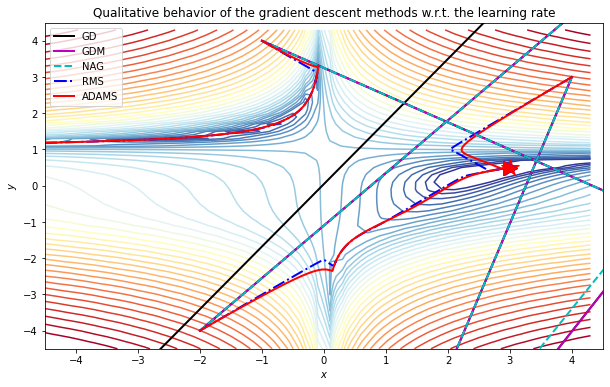

In [153]:
plt.close()
#Make static plot of the results
Nsteps=10**4
lr_l=10**-3
lr_s=10**-3

init1=np.array([4,3])
fig1, ax1=contour_beales_function()

gd_trajectory1=gd(grad_beales_function,init1,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory1=gd_with_mom(grad_beales_function,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory1=NAG(grad_beales_function,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory1=rms_prop(grad_beales_function,init1,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory1=adams(grad_beales_function,init1,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GD','k')
overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory1, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory1,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory1,'ADAMS', 'r')

plt.legend(loc=2)

init3=np.array([-1,4])

gd_trajectory3=gd(grad_beales_function,init3,10**5, eta=lr_s, noise_strength=0)
gdm_trajectory3=gd_with_mom(grad_beales_function,init3,10**5,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory3=NAG(grad_beales_function,init3,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory3=rms_prop(grad_beales_function,init3,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory3=adams(grad_beales_function,init3,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory3, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory3, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory3, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory3,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory3,'ADAMS', 'r')

init4=np.array([-2,-4])

gd_trajectory4=gd(grad_beales_function,init4,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory4=gd_with_mom(grad_beales_function,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory4=NAG(grad_beales_function,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory4=rms_prop(grad_beales_function,init4,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory4=adams(grad_beales_function,init4,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory4, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory4, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory4, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory4,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory4,'ADAMS', 'r')

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Qualitative behavior of the gradient descent methods w.r.t. the learning rate")
plt.show()

With a small learning rate $\eta = 10^{-6}$ nor ADAM neither RMS leave their initial position... The other methods follow the slope until they reach their final positions.

With a large learning rate $\eta=10^{-6}$,GD, GDM and NAG tend to quickly diverge (their initial velocity is high), while RMS and ADM turn out to be more consistent.

## Conclusion

In this notebook we have discovered some common gradient descent methods. We gain some insights on the crucial influence of the learning rate and the relative dependence to the initial position. It appears that methods exploiting the second moment of the gradient are somehow more reliable.